In [1]:
import matplotlib.pyplot as plt
from main import debugging
try:
    %matplotlib inline
except NameError:  # in case it's a script. 
    pass

import os
import menpo.io as mio
from menpo.image import Image
import numpy as np
from menpo.shape import PointTree, PointUndirectedGraph
from menpofit.dpm.utils import convolve_python_f, call_shiftdt
from menpofit.dpm import HogFeaturePyramid, DPMFitter, non_max_suppression_fast, clip_boxes, bb_to_lns, DPMLearner
from menpofit.dpm.main import *

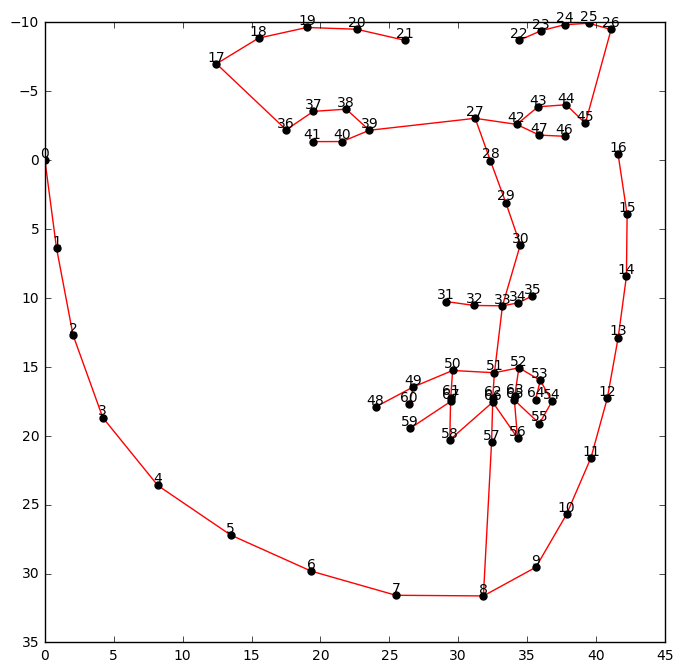

In [2]:
from main import visualize_tree
points = visualize_tree()
from resnet_feature_pyramid import ResnetFeaturePyramid
pickle_dev = '/vol/atlas/homes/ks3811/pickles/resnet/multipie'
model_name = '50pos_component_0.pkl'
resnet = ResnetFeaturePyramid()
model = get_model(pickle_dev, model_name, resnet)
components = model.components
front_face_component = components[0]
tree = front_face_component['tree']
new_tree = PointTree(points, tree.adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
new_tree.view(render_numbering=True)

from ibugnet.utils import rescale_image
image = mio.import_builtin_asset('takeo.ppm', normalize=False)
image = image.crop_to_landmarks_proportion(0.2)
image = rescale_image(image)
# image.view()

In [3]:
print(points)

[[  0.00000000e+00   0.00000000e+00]
 [  6.38263276e+00   8.41553713e-01]
 [  1.26831345e+01   2.03873052e+00]
 [  1.86802142e+01   4.19753259e+00]
 [  2.36083712e+01   8.19398594e+00]
 [  2.71995934e+01   1.34757826e+01]
 [  2.98215266e+01   1.93186470e+01]
 [  3.15762707e+01   2.54717587e+01]
 [  3.16232988e+01   3.18247693e+01]
 [  2.95407468e+01   3.56336075e+01]
 [  2.56991469e+01   3.78604991e+01]
 [  2.15962286e+01   3.96308611e+01]
 [  1.72810628e+01   4.08157063e+01]
 [  1.28691020e+01   4.16072650e+01]
 [  8.42056245e+00   4.22064669e+01]
 [  3.93412793e+00   4.22555941e+01]
 [ -4.59530369e-01   4.15960948e+01]
 [ -6.99907976e+00   1.24503373e+01]
 [ -8.86128043e+00   1.55036243e+01]
 [ -9.63504934e+00   1.90118469e+01]
 [ -9.50768633e+00   2.26189591e+01]
 [ -8.70759036e+00   2.61097679e+01]
 [ -8.69048022e+00   3.43823440e+01]
 [ -9.39548738e+00   3.60006818e+01]
 [ -9.83443897e+00   3.77128975e+01]
 [ -9.94147680e+00   3.94667749e+01]
 [ -9.48894619e+00   4.10939664e+01]
 

1264.37090969
1982.89245986
10520.0158021
15151.2491898
0.637639678038
0.694333230899
8.32035577656
7.64098381357


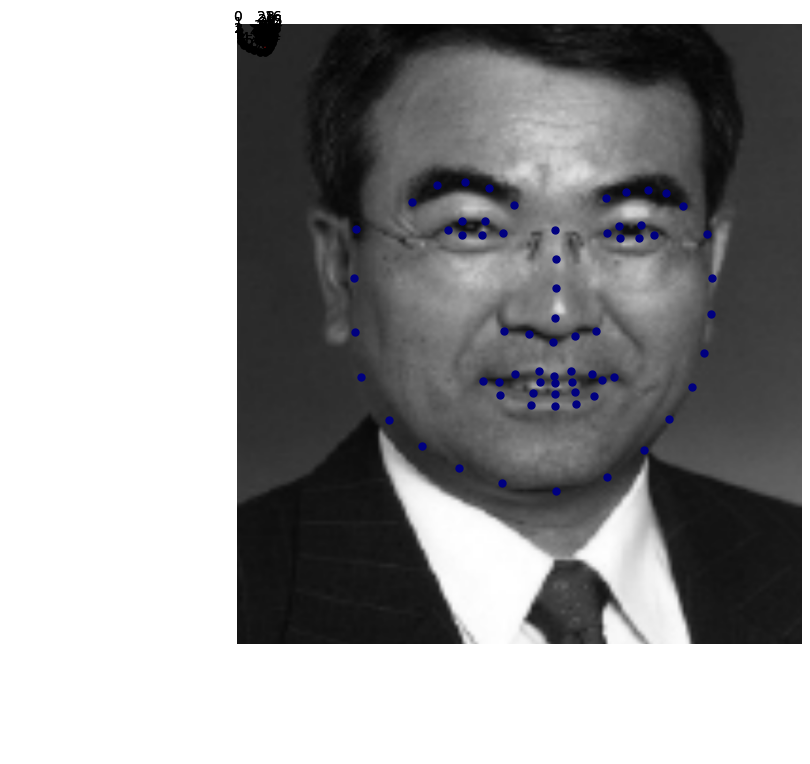

In [4]:
new_tree = PointTree(points, tree.adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
new_tree.view(render_numbering=True)
new_tree.view(render_numbering=True)

small_y = np.sum(points[:, 0]-np.min(points[:, 0]))
small_x = np.sum(points[:, 1]-np.min(points[:, 1]))
print(small_y)
print(small_x)

from ibugnet.utils import rescale_image
image = mio.import_builtin_asset('takeo.ppm', normalize=False)
# image = mio.import_image('/vol/hci2/Databases/video/MultiPIE/session01/png/001/01/05_1/001_01_01_051_05.png', normalize=False)
# image.landmarks['all'] = PointCloud(pos[0]['pts'])
image = image.crop_to_landmarks_proportion(0.5)
image = rescale_image(image)
image.view_landmarks()
ys = image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 0]
xs = image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 1]
big_y = np.sum(ys - np.min(ys))
big_x = np.sum(xs - np.min(xs))

print(big_y)
print(big_x)

print(small_y/small_x)
print(big_y/big_x)

print(big_y/small_y)
print(big_x/small_x)

In [5]:
learner = DPMLearner()
pos, neg = learner._get_frontal_pie_image_info(pickle_dev)
print(pos[0])

{'pts': array([[ 208.85560895,  255.32669716],
       [ 230.83815751,  257.86552192],
       [ 252.59876165,  261.24518985],
       [ 274.20444669,  264.79263945],
       [ 295.00642976,  271.86768945],
       [ 310.32832875,  287.44252797],
       [ 321.27084542,  306.50019306],
       [ 328.35296301,  327.07247704],
       [ 326.59210733,  348.70062646],
       [ 322.54661187,  367.52565511],
       [ 311.05346921,  383.63798168],
       [ 299.22985683,  399.41087926],
       [ 283.09949142,  410.36498402],
       [ 263.85929138,  414.32041467],
       [ 244.08908659,  414.80248234],
       [ 224.46431577,  415.37847178],
       [ 205.23098879,  411.78946745],
       [ 176.75566923,  268.3196206 ],
       [ 169.7202303 ,  280.11868378],
       [ 167.94276749,  293.86649782],
       [ 169.59988892,  307.55701998],
       [ 176.75566923,  319.04549808],
       [ 166.61049374,  354.94381138],
       [ 161.05147132,  365.2769276 ],
       [ 160.86524584,  377.18081041],
       [ 164.5020

In [6]:
def distance_transform(scores, def_coefs, tree, anchors=None):
    r"""
    Given the (unary) scores it computes the pairwise scores by utilising the Generalised Distance
    Transform.

    Parameters
    ----------
    scores: `list`
        The (unary) scores to which the pairwise score will be added.
    tree: `:map:`Tree``
        Tree with the parent/child connections.
    def_coef: `list`
        Each element contains a 4-tuple with the deformation coefficients for that part.
    anchors:
        Contains the anchor position in relation to the parent of each part.

    Returns
    -------
    scores: `ndarray`
        The (unary + pairwise) scores.
    Ix: `dict`
        Contains the coordinates of x for each part from the Generalised Distance Transform.
    Iy: `dict`
        Contains the coordinates of y for each part from the Generalised Distance Transform.
    """
    iy, ix = {}, {}
    for depth in range(tree.maximum_depth, 0, -1):
        for curr_vert in tree.vertices_at_depth(depth):
            parent = tree.parent(curr_vert)
            (ny, nx) = scores[parent].shape
            w = def_coefs[curr_vert] * -1.00
            (cx, cy, _) = anchors[curr_vert]
            msg, ix1, iy1 = call_shiftdt(scores[curr_vert], np.array(w, dtype=np.double), cx, cy, nx, ny, 1)
            scores[parent] += msg
            ix[curr_vert] = ix1
            iy[curr_vert] = iy1
    return scores, ix, iy

def get_model(pickle, model_name, feature_pyramid=None):
    file_name = os.path.join(pickle, model_name)
    model = mio.import_pickle(file_name, encoding="latin1")
    model.interval = 10  # Use deeper pyramid when detecting actual objects
    if feature_pyramid is not None:
        model.feature_pyramid = feature_pyramid
    return model

In [7]:
pickle_dev = '/vol/atlas/homes/ks3811/pickles/resnet/multipie'
model_name = '50pos_component_0.pkl'
model = get_model(pickle_dev, model_name, resnet)

filters_all = model.get_filters_weights()
defs_all = model.get_defs_weights()
anchors_all = model.get_defs_anchors()
components = model.components

front_face_component = components[0]

5102.29832463
5563.67571149
0.637639678038
0.91707327839
4.03544425575
2.80583835186


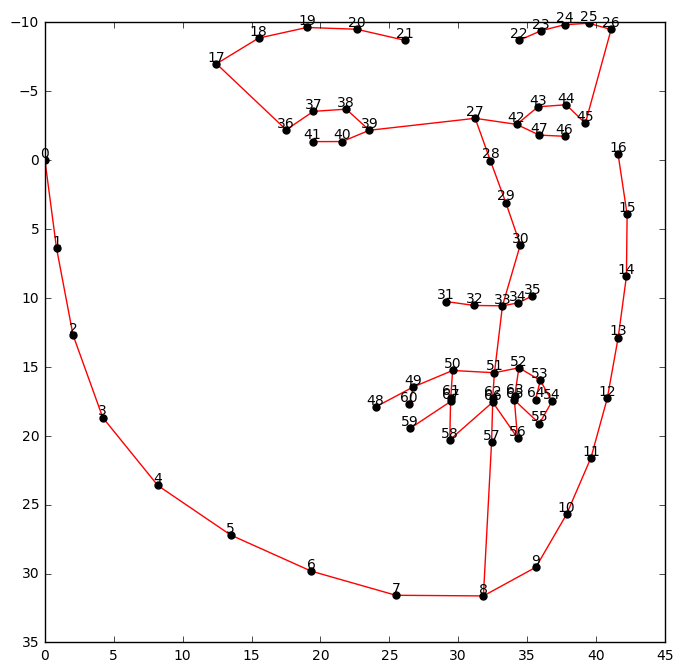

In [8]:
from ibugnet.utils import (caffe_preprocess, rescale_image)
image = mio.import_builtin_asset('takeo.ppm', normalize=False)
image = mio.import_image('/vol/hci2/Databases/video/MultiPIE/session01/png/001/01/05_1/001_01_01_051_05.png', normalize=False)
image.landmarks['all'] = PointCloud(pos[0]['pts'])
image = image.crop_to_landmarks_proportion(0.5)
# image = rescale_image(image)
# fea = resnet.extract_feature(image)
# print(fea.shape)
# plt.imshow(fea.argmax(0))
# plt.imshow(fea[34, :, :])
# image.view_landmarks(alpha=0.6)
# image.view_landmarks()
# visualise_fit_image(image, model)

ys = image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 0]
xs = image.landmarks[image.landmarks.group_labels[0]].lms.points[:, 1]
big_y = np.sum(ys - np.min(ys))
big_x = np.sum(xs - np.min(xs))

print(big_y)
print(big_x)

print(small_y/small_x)
print(big_y/big_x)

print(big_y/small_y)
print(big_x/small_x)

new_tree.view(render_numbering=True)

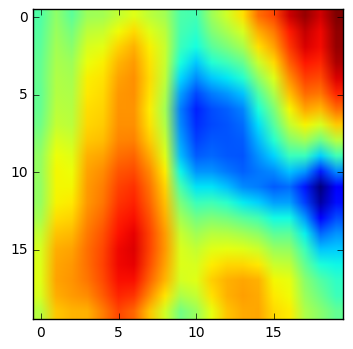

In [9]:
plt.imshow(model.filters[0]['w'][5])

In [10]:
#get tree, defs, and anchors of frontal face component
from ibugnet.utils import (caffe_preprocess, rescale_image)
tree = front_face_component['tree']
filter_ids = front_face_component['filter_ids']
def_ids = front_face_component['def_ids']
defs = np.array(defs_all)[def_ids]
anchors = np.array(anchors_all)[def_ids]

#this is just to compute the score of each part.
image = mio.import_builtin_asset('takeo.ppm', normalize=False)
image = image.crop_to_landmarks_proportion(0.2)
image = rescale_image(image)
padding = (model.maxsize[0] - 1, model.maxsize[1] - 1)
feats, scales, shifts = model.feature_pyramid.extract_pyramid(image, model.interval, padding)
feat = feats[0]
unary_scores_all = convolve_python_f(feat, filters_all)
scores = np.array(unary_scores_all)[filter_ids]

transform_scores, ix, iy = distance_transform(scores, defs, tree, anchors)

#root is at the tip of the nose
root_pixels = transform_scores[0]
root_pixels -= np.min(root_pixels)
root_pixels /= 255
root_score = Image(root_pixels.clip(0, 1))
root_score = root_score.resize(image.shape)

plt.imshow(root_score.pixels[0])

image.view(alpha=.6)

ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [ ]:
from menpo.shape import PointCloud
from ibugnet.utils import (caffe_preprocess, rescale_image)
# image = mio.import_image('/vol/atlas/databases/aflw_ibug/face_40085.jpg', normalise=False)
image = mio.import_builtin_asset('takeo.ppm', normalize=False)
image = image.crop_to_landmarks_proportion(0.2)
# image = rescale_image(image)
# boxes = DPMFitter.fast_fit_from_model(image, model, 0, return_once=True)

# boxes.sort(key=lambda item: item['s'], reverse=True)
# cc, pick = non_max_suppression_fast(clip_boxes(boxes), 0.3)
# lns = bb_to_lns(boxes, pick)

from main import visualize_tree


new_tree = PointTree(lns[0], tree.adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
new_tree.view()

image.landmarks['all'] = PointCloud(lns[0])

# plt.imshow(root_score.pixels[0])
image.view(alpha=.6)
# image.view_landmarks(group='all')

In [ ]:
from ibugnet.utils import rescale_image


im = mio.import_image('/vol/atlas/databases/aflw_ibug/face_50970.jpg', normalise=False)
# print(mio.import_landmark_file('/vol/atlas/databases/aflw_ibug/face_40085.ljson').lms.points)
# im.landmarks['all'] = mio.import_landmark_file('/vol/atlas/databases/aflw_ibug/face_52982.ljson').lms
# im = im.crop_to_landmarks_proportion(0.2, group='test')
# im.view_landmarks(render_numbering=True, group='test')

# im.view_landmarks()
# print(im.landmarks.values)
# im.shape
im=im.crop_to_landmarks_proportion(0.2)
# im = rescale_image(im)
im.view_landmarks()

print(im.shape)
# landmarks = mio.import_landmark_file('/vol/atlas/databases/aflw_ibug/face_52982.ljson')

In [ ]:
from menpo.shape import PointCloud
learner = DPMLearner()
points = np.array([[ 266.04368381,  320.65935687],
 [ 260.94626045,  328.46085126],
 [ 261.16349946,  337.50968759],
 [ 272.9061885 ,  314.21115142],
 [ 272.37312603,  316.55255966],
 [ 166.61049374,  354.94381138],
 [ 161.05147132,  365.2769276 ],
 [ 160.86524584,  377.18081041],
 [ 164.50206064,  388.32678416],
 [ 263.19456707,  355.39102411],
 [ 267.95879029,  363.68513351],
 [ 267.98675042,  359.68525318],
 [ 259.19512028,  346.62841639],
 [ 267.6619464 ,  338.98343969],
 [ 267.9633976 ,  327.38701488],
 [ 167.94276749,  293.86649782],
 [ 169.59988892,  307.55701998],
 [ 176.75566923,  319.04549808],
 [ 189.06601612,  357.14357365],
 [ 194.14640995,  364.79185152],
 [ 266.2634257 ,  349.40412971],
 [ 273.78637473,  330.56091267],
 [ 268.23827489,  338.98343969],
 [ 272.05766494,  356.06249316],
 [ 266.70279764,  349.2538412 ],
 [ 273.03179053,  347.30350886],
 [ 173.63407677,  395.52451337],
 [ 187.96427972,  381.93264257],
 [ 180.18385827,  374.33428092],
 [ 180.16312623,  363.26581315],
 [ 193.30729959,  374.17943011],
 [ 326.59210733,  348.70062646],
 [ 274.56631383,  338.72812526],
 [ 273.94428227,  322.26491258],
 [ 268.40989766,  327.37696506],
 [ 322.54661187,  367.52565511],
 [ 311.05346921,  383.63798168],
 [ 299.22985683,  399.41087926],
 [ 328.35296301,  327.07247704],
 [ 321.27084542,  306.50019306],
 [ 310.32832875,  287.44252797],
 [ 263.85929138,  414.32041467],
 [ 283.09949142,  410.36498402],
 [ 295.00642976,  271.86768945],
 [ 244.08908659,  414.80248234],
 [ 274.20444669,  264.79263945],
 [ 224.46431577,  415.37847178],
 [ 230.83815751,  257.86552192],
 [ 205.23098879,  411.78946745],
 [ 208.85560895,  255.32669716],
 [ 252.59876165,  261.24518985],
 [ 179.09686358,  333.09266416],
 [ 194.29484788,  333.75863705],
 [ 209.30063987,  336.13273099],
 [ 224.35995425,  337.77505285],
 [ 237.24846688,  349.56682135],
 [ 239.31611605,  344.09665875],
 [ 238.84262853,  325.74929414],
 [ 239.28606548,  331.96811107],
 [ 239.5777175 ,  338.15927184],
 [ 192.92209351,  306.18826532],
 [ 198.46518004,  298.98077177],
 [ 199.71922959,  290.05918643],
 [ 186.22826984 , 298.17753439],
 [ 187.73052783  ,287.54372927],
 [ 196.46296416 , 281.69851472],
 [ 176.75566923 , 268.3196206 ],
 [ 169.7202303  , 280.11868378]]
)
pos, neg = learner._get_frontal_pie_image_info('/vol/atlas/homes/ks3811/pickles/resnet/multipie')
pos[0]['pts']

im = mio.import_image(pos[0]['im'], normalize=True)
im.landmarks['all'] = PointCloud([pos[0]['pts'][0]])
# im = im.crop_to_landmarks_proportion(0.2)
im.view_landmarks()

# new_tree = PointTree(pos[0]['pts'], learner.get_aflw_tree(0).adjacency_matrix.todense(), tree.root_vertex, skip_checks=True)
# new_tree.view()

In [ ]:
from resnet_feature_pyramid import ResnetFeaturePyramid
pickle_dev = '/vol/atlas/homes/ks3811/pickles/resnet/fast'
model_name = 'parts_model_0.pkl'
model = get_model(pickle_dev, model_name, ResnetFeaturePyramid())

In [ ]:
response = DPMFitter.get_part_response(im, model, 0)

In [ ]:
plt.imshow(response)
im.view(alpha=.6)

In [ ]:
from menpo.shape import PointCloud
im = mio.import_image('/vol/atlas/databases/aflw_ibug/face_52982.jpg')
im = im.crop([149.0, 31.0], [1167.0, 1047.0])
im.view()
# im.landmarks['all'] = PointCloud(np.array([[46, 351]]))
# # im.landmarks['all'] = mio.import_landmark_file('/vol/atlas/databases/aflw_ibug/face_42755.ljson').lms
# im.view_landmarks(group='all', render_numbering=True)